In [1]:
from lib.qui_quadrado import QuiQuadrado
from lib.teste_ks import KolmogorovSmirnov
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

In [2]:
modelo = pd.read_csv('modelo_csv.csv', sep=';')
modelo.head()

,idade,qtda_vivo,qtda_morte
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


In [3]:
df_tabuas = pd.read_excel('Funções Biométricas (Com Fórmulas).xlsx', sheet_name='qx')
df_tabuas.head()

,ALLG-72,AMERICAN EXPERIENCE,AT2000 (Suavizada 10%)_FEM,AT2000 (Suavizada 10%)_MAS,AT-2000 FEMALE,AT-2000 MALE,AT-49 FEMALE,AT-49 MALE,AT-50,AT-55,AT-71,AT-83 FEMALE (Basic),AT-83 FEMALE (IAM),AT-83 MALE (Basic),AT-83 MALE (IAM),BR-EMSmt-v.2010-f,BR-EMSmt-v.2010-m,BR-EMSsb-v.2010-f,BR-EMSsb-v.2010-m,BR-EMSmt-v.2015-f,BR-EMSmt-v.2015-m,BR-EMSsb-v.2015-f,BR-EMSsb-v.2015-m,BR-EMSmt-v.2021-f,BR-EMSmt-v.2021-m,BR-EMSsb-v.2021-f,BR-EMSsb-v.2021-m,CSG-60,CSO-41,CSO-58,CSO58 - FEM - AGE LAST,CSO58 - FEM - AGE NEAREST,CSO58 - MAS - AGE LAST,CSO58 - MAS - AGE NEAREST,CSO58 FEMALE,CSO58 MALE,CSO80,EB7-75,GAM-71 FEMALE,GAM-71 MALE,GAM-83 - FEMALE (suav 10%),GAM83_BÁSICA - FEMALE,GAM83_BÁSICA - MASC,GAM-83 - MASC (suav 10%),GAM-94 FEMALE,GAM-94MALE,GKF-95,GKM-70,GKM-80,GKM-95,GR-95 MALE,GR-95FEMALE,GRUPAL AMERICANA,HUNTER SEMITROPICAL,IBGE 2006 Ambos os Sexos,IBGE 2007 Ambos os Sexos,IBGE 2008 Ambos os Sexos,IBGE 2009 Ambos os Sexos,Prudential-50,Rentiers Français,RP-2000 FEMALE,RP-2000MALE,SGB-51,SGB-71,SGB-75,UP-84 F,UP-84 M,UP84_MAS_&_FEM,UP-94 FEMALE,UP-94 MALE,USTP-61,X-17,BENTZIEN,Experiência CAP,GRUPAL AMERICANA.1,IAPC,IBA (FERROVIARIOS),MULLER,RP-2000 DISABLED FEMALE,RP-2000 DISABLED MALE,RRB-44,TASA/1927,WINKLEVOSS,ZIMMERMANN,ZIMMERMANN (FERR. ALEMAES),ALVARO VINDAS,GRUPO AMERICANA,HUNTER'S,IAPB-57 Forte,IAPB-57 FRACA,IBA (FERROVIARIOS).1,LIGHT FORTE,LIGHT MEDIA,MULLER.1,PRUDENTIAL (FERR. APOSENT.),RGPS-99/02 M.M,RRB-1944 Mod - Fem,RRB-1944 Mod - Masc,TASA-1927,WYATT 1985,ZIMMERMANN EMPR. ESCRIT
0,1.3,0.15470,0.001615,0.002080,0.001794,0.002311,0.003210,0.004040,0.0,0.0,0.0,0.0,0.001835,0.0,0.002690,0.00128,0.00274,0.00038,0.00200,0.000415,0.000391,0.000344,0.000337,0.000355,0.000371,0.000293,0.000353,0.00832,0.02258,0.00708,0.003942,0.00620,0.004430,0.00708,0.00548,0.00633,0.00418,0.0,0.002219,0.003255,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024891,0.024036,0.023295,0.022467,0.0,0.03602,0.000000,0.000000,0.0,0.001295,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.3,0.06349,0.000680,0.000815,0.000755,0.000906,0.001360,0.001580,0.0,0.0,0.0,0.0,0.000778,0.0,0.001053,0.00046,0.00095,0.00038,0.00069,0.000184,0.000202,0.000153,0.000157,0.000226,0.000242,0.000192,0.000226,0.00207,0.00577,0.00176,0.001540,0.00167,0.001640,0.00176,0.00094,0.00100,0.00107,0.0,0.000940,0.001274,0.0,0.0,0.0,0.0,0.000531,0.000592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002292,0.002182,0.002291,0.002152,0.0,0.02749,0.000571,0.000637,0.0,0.001295,0.0,0.0,0.0,0.0,0.000571,0.000637,0.0,0.0,0.0,0.0,0.449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.3,0.03550,0.000353,0.000454,0.000392,0.000504,0.000703,0.000887,0.0,0.0,0.0,0.0,0.000402,0.0,0.000591,0.00025,0.00048,0.00020,0.00035,0.000105,0.000135,0.000116,0.000094,0.000195,0.000213,0.000155,0.000196,0.00179,0.00414,0.00152,0.001380,0.00141,0.001490,0.00152,0.00067,0.00075,0.00099,0.0,0.000486,0.000715,0.0,0.0,0.0,0.0,0.000346,0.000400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001255,0.001198,0.001188,0.001132,0.0,0.02085,0.000372,0.000430,0.0,0.001295,0.0,0.0,0.0,0.0,0.000372,0.000430,0.0,0.0,0.0,0.0,0.436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.3,0.02391,0.000261,0.000367,0.000290,0.000408,0.000521,0.000715,0.0,0.0,0.0,0.0,0.000298,0.0,0.000476,0.00016,0.00030,0.00013,0.00022,0.000073,0.000107,0.000079,0.000069,0.000180,0.000199,0.000134,0.000181,0.00172,0.00338,0.00146,0.001320,0.00135,0.001430,0.00146,0.00060,0.00068,0.00098,0.0,0.000360,0.000576,0.0,0.0,0.0,0.0,0.000258,0.000332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000922,0.000880,0.000778,0.000750,0.0,0.01575,0.000278,0.000357,0.0,0.001295,0.0,0.0,0.0,0.0,0.000278,0.000357,0.0,0.0,0.0,0.0,0.423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [10]:
def aplicar_fator_desloc(tabua, fator, desloc):
    tabua_ajustada = tabua * (1 + (fator / 100))
    tabua_ajustada = np.roll(tabua_ajustada, int(desloc))
    return tabua_ajustada

In [11]:
observado = modelo['qtda_morte']#.view(NDArray)  # Frequências observadas
esperado = modelo['qtda_vivo'].values * (df_tabuas['CSO-58'] * (1 + (-52.70 / 100)))

In [12]:
from skopt import gp_minimize

# Definir os limites para os parâmetros
espaco_parametros = [(-100.0, 100.0), (-5.0, 5.0)]  # limites para fator e desloc

# Lista para armazenar os resultados para cada tabela
resultados = []

# Etapa 1: encontrar as tabelas mais promissoras
for tabela_mortalidade in df_tabuas.columns:
    def funcao_objetivo_tabela(parametros):
        fator = parametros[0]
        desloc = parametros[1]
        tabela_mortalidade_modificada = aplicar_fator_desloc(tabela_mortalidade, fator, desloc)

        f_esp_modificado = modelo['qtda_vivo'].values * tabela_mortalidade_modificada[tabela_mortalidade]

        teste_qui_quadrado = QuiQuadrado(f_obs=observado, f_esp=f_esp_modificado)
        resultado_qui_quadrado = teste_qui_quadrado.calcular_qui_quadrado(grau_liberdade=1)

        teste_ks = KolmogorovSmirnov(f_obs=observado, f_esp=f_esp_modificado)
        resultado_ks = teste_ks.calcular_ks(grau_liberdade=1)

        # A função objetivo deve retornar um único valor, então você pode retornar a soma dos valores dos testes
        return resultado_qui_quadrado['Qui-Quadrado calculado'] + resultado_ks['KS calculado']

    # Executar a otimização bayesiana
    resultado = gp_minimize(funcao_objetivo_tabela, espaco_parametros, n_calls=50, random_state=0)

    # Adicionar o resultado à lista
    resultados.append((tabela_mortalidade, resultado))

# Ordenar os resultados pelo valor mínimo da função objetivo (ou seja, o melhor resultado)
resultados_ordenados = sorted(resultados, key=lambda x: x[1].fun)

# Selecionar as N tabelas mais promissoras
N = 5
tabelas_mais_promissoras = [x[0] for x in resultados_ordenados[:N]]

# Etapa 2: para cada uma das tabelas mais promissoras, encontrar os melhores parâmetros de agravamento, suavização e atraso
for tabela_mortalidade in tabelas_mais_promissoras:
    # Aqui você pode repetir o processo de otimização bayesiana, mas desta vez otimizando os parâmetros de agravamento, suavização e atraso para a tabela_mortalidade
    pass

TypeError: can't multiply sequence by non-int of type 'float'

In [20]:
from skopt import gp_minimize

def callback(res):
    print(f'Iteração: {len(res.x_iters)}')
    print(f'x: {res.x}')
    print(f'Função objetivo: {res.fun}')

# Definir a função que queremos minimizar
def funcao_objetivo(params):
    a = params[0]
    b = params[1]
    result1 = (a - 2) ** 2
    result2 = (b - 3) ** 2
    result = result1 - result2
    #print(result, a, b)
    return result

# Definir os limites para os parâmetros
espaco_parametros = [(-10.0, 10.0), (-10.0, 10.0)]

# Executar a otimização bayesiana
resultado = gp_minimize(funcao_objetivo, espaco_parametros, n_calls=50, callback=callback, random_state=0)

# Os melhores parâmetros estão no atributo "x" do objeto de resultado
melhores_parametros = resultado.x

print(f"Melhores parâmetros: {melhores_parametros}")

Iteração: 1
x: [1.8568923645003679, 6.88531497162035]
Função objetivo: -15.075192633358943
Iteração: 2
x: [1.8568923645003679, 6.88531497162035]
Função objetivo: -15.075192633358943
Iteração: 3
x: [2.4712739357194486, -2.3123658541460017]
Função objetivo: -27.99913184580788
Iteração: 4
x: [-4.049307869110553, -8.865740453651137]
Função objetivo: -104.20167081813022
Iteração: 5
x: [-4.049307869110553, -8.865740453651137]
Função objetivo: -104.20167081813022
Iteração: 6
x: [-4.049307869110553, -8.865740453651137]
Função objetivo: -104.20167081813022
Iteração: 7
x: [-4.049307869110553, -8.865740453651137]
Função objetivo: -104.20167081813022
Iteração: 8
x: [-4.049307869110553, -8.865740453651137]
Função objetivo: -104.20167081813022
Iteração: 9
x: [-4.049307869110553, -8.865740453651137]
Função objetivo: -104.20167081813022
Iteração: 10
x: [-4.049307869110553, -8.865740453651137]
Função objetivo: -104.20167081813022
Iteração: 11
x: [-4.049307869110553, -8.865740453651137]
Função objetivo:

In [21]:
import plotly.graph_objects as go
# Gerar o gráfico de convergência usando Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(resultado.func_vals) + 1)),
    y=resultado.func_vals,
    mode='lines+markers',
    name='Convergência'
))

fig.update_layout(
    title='Convergência da Otimização Bayesiana',
    xaxis_title='Iteração',
    yaxis_title='Função Objetivo',
)

fig.show()

In [22]:
resultado.func_vals

array([ -15.07519263,   11.05107728,  -27.99913185, -104.20167082,
         30.98183588,    6.44312302,    3.32513379,   27.5829738 ,
        -16.25292313,   65.13560151,  -27.58568447, -133.19293784,
       -144.47981447, -152.4199887 , -163.48835138, -167.77874077,
       -168.61938675, -168.99285747, -168.99897761, -168.9991091 ,
       -168.99913303, -105.        , -168.99992809, -168.99985515,
       -168.99971239, -167.52091325, -168.79631748, -168.99958775,
       -168.99999969, -168.78750103, -165.73667049, -168.99998963,
       -168.99998732, -168.99998508, -168.99998596, -168.99998671,
       -168.88879842, -168.99998807, -168.99999998, -168.9999878 ,
       -168.9065718 , -168.99998883, -168.99997332, -168.99998423,
       -168.9999862 , -168.99998398, -168.99998764, -168.99998256,
       -168.99998958, -168.99998238])

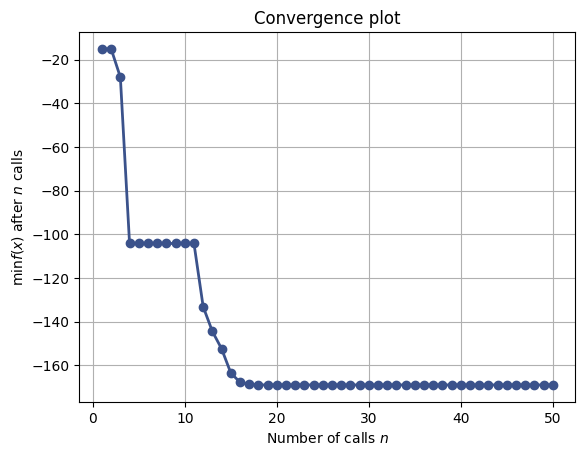

In [23]:
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt

plot_convergence(resultado)
plt.show()

In [ ]:
from pydantic import BaseModel
from typing import List

class TestToShowTheStupidArthurThePowerOfPython(BaseModel):
    test_int: int = None
    test_float: float
    test_str: str = 'Teste'

    def return_as_list_of_lists(self) -> List[List]:
        return [[self.test_int], [self.test_float], [self.test_str]]

ttstsatpop = TestToShowTheStupidArthurThePowerOfPython(test_float=1.0)
result = ttstsatpop.return_as_list_of_lists()
result

In [ ]:
observado = np.array(modelo['qtda_morte'])#.view(NDArray)  # Frequências observadas
esperado = modelo['qtda_vivo'].values * (df_tabuas['CSO-58'] * (1 + (-52.70 / 100)))

In [19]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Integer, Real
from pydantic import BaseModel, Field
from typing import List, Tuple
from lib.qui_quadrado import QuiQuadrado
from lib.teste_ks import KolmogorovSmirnov
from lib.utils import aplicar_fator_desloc

class OtimizacaoBayesiana(BaseModel):
    f_obs: np.array = Field(...)
    f_vivos: np.array = Field(...)
    tabuas: pd.DataFrame = Field(...) 
    index: dict = None

    class Config:
        arbitrary_types_allowed = True

    def _get_index_tabuas(self):
        self.index = {key: value for key, value in enumerate(self.tabuas.columns)}

    def callback(self, res):
        print(f"Iteração nº {len(res.x_iters)} - Tábua {self.index[res.x[0]]} - Parâmetros {res.x} - Função Objetivo {res.fun}") 

    def funcao_objetivo(self, parametros):
        tabua = parametros[0]
        fator = parametros[1]
        desloc = parametros[2]

        f_esp_modificado = aplicar_fator_desloc(tabua=np.array(self.tabuas.iloc[:, tabua]), fator=fator, desloc=desloc)

        qq = QuiQuadrado(f_obs=self.f_obs, f_esp=f_esp_modificado)
        resultado_qui_quadrado = qq.calcular_qui_quadrado()

        ks = KolmogorovSmirnov(f_obs=self.f_obs, f_esp=f_esp_modificado)
        resultado_ks = ks.calcular_ks()

        penalidade_qui_quadrado = 99999 if resultado_qui_quadrado['Decisão Baseada no valor crítico'] == 'Rejeitar H₀' else 0
        penalidade_ks = 99999 if resultado_ks['Decisão Baseada no valor crítico'] == 'Rejeitar H₀' else 0

        return resultado_qui_quadrado['Qui-Quadrado calculado'] + resultado_ks['KS calculado'] + penalidade_qui_quadrado + penalidade_ks
    
    def aplicar_otimizacao(self, espaco_parametros: List[tuple], n_calls: int = 100, random_state: int = 0):
        self._get_index_tabuas()
        gp_minimize(self.funcao_objetivo, espaco_parametros, n_calls=n_calls, random_state=random_state, callback=self.callback)
    

c:\Users\italo\miniconda3\envs\venv_adherence_test\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning:

<built-in function array> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.



In [ ]:
ob = OtimizacaoBayesiana(f_obs=observado, f_vivos=np.array(modelo['qtda_vivo'].values), tabuas=df_tabuas)
ob.aplicar_otimizacao(espaco_parametros=[Integer(0, df_tabuas.shape[1]-1), 
                                         Integer(-10.0, 10.0), 
                                         Integer(-5.0, 5.0)])

In [ ]:
def aplicar_fator_desloc(tabua, fator, desloc):
    tabua_ajustada = tabua * (1 + (fator / 100))
    tabua_ajustada = np.roll(tabua_ajustada, int(desloc))
    tabua_ajustada[tabua_ajustada > 1] = 1
    return tabua_ajustada

In [ ]:
observado = np.array(modelo['qtda_morte'])#.view(NDArray)  # Frequências observadas
tabua_ = aplicar_fator_desloc(tabua=df_tabuas['CSO58 - MAS - AGE NEAREST'], fator=-100.0, desloc=5)
esperado = modelo['qtda_vivo'].values * tabua_

mask = ~np.logical_and(observado == 0, esperado == 0)
f_obs_filtrado = observado#[mask]
f_esp_filtrado = esperado#[mask]

In [ ]:
a = pd.DataFrame([f_obs_filtrado, f_esp_filtrado, f_obs_filtrado - f_esp_filtrado, (f_obs_filtrado - f_esp_filtrado)**2, (f_obs_filtrado - f_esp_filtrado)**2/f_esp_filtrado])
a

In [ ]:
qq = QuiQuadrado(f_obs=f_obs_filtrado, f_esp=f_esp_filtrado)
qq.calcular_qui_quadrado()

In [11]:
import logging
from lib.qui_quadrado import QuiQuadrado
from lib.teste_ks import KolmogorovSmirnov
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

modelo = pd.read_csv('modelo_csv.csv', sep=';')
df_tabuas = pd.read_excel('Funções Biométricas (Com Fórmulas).xlsx', sheet_name='qx')

import numpy as np
from skopt import gp_minimize
from skopt.space import Integer, Real
from pydantic import BaseModel, Field
from typing import List, Tuple
from lib.qui_quadrado import QuiQuadrado
from lib.teste_ks import KolmogorovSmirnov
from lib.utils import aplicar_fator_desloc

logging.basicConfig(level=logging.INFO)

class OtimizacaoBayesiana(BaseModel):
    f_obs: np.array = Field(...)
    f_vivos: np.array = Field(...)
    tabuas: pd.DataFrame = Field(...) 
    index: dict = Field(default_factory=dict)
    resultado_dict: dict = Field(default_factory=dict)

    class Config:
        arbitrary_types_allowed = True

    def __init__(self, **data):
        super().__init__(**data)
        self.get_index_tabuas()

    def get_index_tabuas(self):
        self.index = {key: value for key, value in enumerate(self.tabuas.columns)}

    def callback(self, res):
        #logging.info(f"Iteração nº {len(res.x_iters)} - Tábua {self.index[res.x[0]]} - Parâmetros {res.x} - Função Objetivo {res.fun}")
        print(f"Iteração nº {len(res.x_iters)} - Tábua {self.index[res.x[0]]} - Parâmetros {res.x} - Função Objetivo {res.fun}") 
        
    def funcao_objetivo(self, parametros):
        tabua = parametros[0]
        fator = parametros[1] if parametros[1] != -100.00 else -99.99 
        desloc = parametros[2]

        f_esp_modificado = aplicar_fator_desloc(tabua=np.array(self.tabuas.iloc[:, tabua]), fator=fator, desloc=desloc) * self.f_vivos
        logging.info(f"parans: {self.index[tabua], fator, desloc}")

        qq = QuiQuadrado(f_obs=self.f_obs, f_esp=f_esp_modificado)
        resultado_qui_quadrado = qq.calcular_qui_quadrado()
        #logging.info(f"resultado_qui_quadrado: {resultado_qui_quadrado}")

        ks = KolmogorovSmirnov(f_obs=self.f_obs, f_esp=f_esp_modificado)
        resultado_ks = ks.calcular_ks()
        #logging.info(f"resultado_ks: {resultado_ks}")

        penalidade_qui_quadrado = 99999 if resultado_qui_quadrado['Decisão Baseada no valor crítico'] == 'Rejeitar H₀' else 0
        penalidade_ks = 99999 if resultado_ks['Decisão Baseada no valor crítico'] == 'Rejeitar H₀' else 0
        #logging.info(f"{penalidade_qui_quadrado, penalidade_ks}")

        func_obj = resultado_qui_quadrado['Qui-Quadrado calculado'] + resultado_ks['KS calculado'] + penalidade_qui_quadrado + penalidade_ks
        #logging.info(f"func_obj: {func_obj}")

        self.resultado_dict[len(self.resultado_dict)+1] = {
            'tabela': self.index[tabua],
            'agravo/suavizacao': fator,
            'delay': desloc,
            'qui_quadrado': resultado_qui_quadrado['Qui-Quadrado calculado'],
            'qui_quadrado_valor_critico': resultado_qui_quadrado['Valor crítico'],
            'decisao_qui_quadrado': resultado_qui_quadrado['Decisão Baseada no valor crítico'],
            'ks': resultado_ks['KS calculado'],
            'ks_valor_critico': resultado_ks['Valor crítico'],
            'ks_qui_quadrado': resultado_ks['Decisão Baseada no valor crítico'],
            'penalidade_qui_quadrado': penalidade_qui_quadrado,
            'penalidade_ks': penalidade_ks,
            'func_obj': func_obj
        }

        return func_obj
    
    def aplicar_otimizacao(self, espaco_parametros: List[tuple], n_calls: int = 50, random_state: int = 0):
        resultado = gp_minimize(self.funcao_objetivo, espaco_parametros, n_calls=n_calls, random_state=random_state)
        melhores_parametros = resultado.x

        return self.resultado_dict

observado = np.array(modelo['qtda_morte'])#.view(NDArray)  # Frequências observadas

c:\Users\italo\miniconda3\envs\venv_adherence_test\Lib\site-packages\pydantic\_internal\_generate_schema.py:404: UserWarning: <built-in function array> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [15]:
ob = OtimizacaoBayesiana(f_obs=observado, f_vivos=np.array(modelo['qtda_vivo'].values), tabuas=df_tabuas)
ob.aplicar_otimizacao(espaco_parametros=[Integer(0, df_tabuas.shape[1]-1), 
                                         Integer(-10.0, 10.0), 
                                         Integer(-5.0, 5.0)])

INFO:root:parans: ('Rentiers Français', np.int64(7), np.int64(4))
INFO:root:parans: ('ALVARO VINDAS', np.int64(2), np.int64(-1))
INFO:root:parans: ('CSO58 - FEM - AGE LAST', np.int64(-9), np.int64(-2))
INFO:root:parans: ('GKM-80', np.int64(6), np.int64(0))
INFO:root:parans: ('GAM-71 MALE', np.int64(7), np.int64(-2))
INFO:root:parans: ('UP-84 F', np.int64(-3), np.int64(5))
INFO:root:parans: ('AT-83 MALE (IAM)', np.int64(7), np.int64(0))
INFO:root:parans: ('RRB-44', np.int64(0), np.int64(2))
INFO:root:parans: ('BENTZIEN', np.int64(2), np.int64(0))
INFO:root:parans: ('IBA (FERROVIARIOS)', np.int64(-8), np.int64(0))
INFO:root:parans: ('CSO58 FEMALE', np.int64(-5), np.int64(4))
INFO:root:parans: ('CSO58 FEMALE', np.int64(9), np.int64(1))
INFO:root:parans: ('BR-EMSmt-v.2015-m', np.int64(-10), np.int64(4))
INFO:root:parans: ('AT-2000 MALE', np.int64(-9), np.int64(5))
INFO:root:parans: ('SGB-75', np.int64(-2), np.int64(5))
INFO:root:parans: ('IBGE 2009                 Ambos os Sexos', np.int64

{1: {'tabela': 'Rentiers Français',
  'agravo/suavizacao': np.int64(7),
  'delay': np.int64(4),
  'qui_quadrado': 5921.5576,
  'qui_quadrado_valor_critico': 101.8795,
  'decisao_qui_quadrado': 'Rejeitar H₀',
  'ks': 0.1173,
  'ks_valor_critico': 0.1347,
  'ks_qui_quadrado': 'Não rejeitar H₀',
  'penalidade_qui_quadrado': 99999,
  'penalidade_ks': 0,
  'func_obj': 105920.6749},
 2: {'tabela': 'ALVARO VINDAS',
  'agravo/suavizacao': np.int64(2),
  'delay': np.int64(-1),
  'qui_quadrado': 6026.6391,
  'qui_quadrado_valor_critico': 101.8795,
  'decisao_qui_quadrado': 'Rejeitar H₀',
  'ks': 0.2413,
  'ks_valor_critico': 0.1347,
  'ks_qui_quadrado': 'Rejeitar H₀',
  'penalidade_qui_quadrado': 99999,
  'penalidade_ks': 99999,
  'func_obj': 206024.8804},
 3: {'tabela': 'CSO58 - FEM - AGE LAST',
  'agravo/suavizacao': np.int64(-9),
  'delay': np.int64(-2),
  'qui_quadrado': 5536.7331,
  'qui_quadrado_valor_critico': 101.8795,
  'decisao_qui_quadrado': 'Rejeitar H₀',
  'ks': 0.1057,
  'ks_valor_

In [16]:
resultado = pd.DataFrame(ob.resultado_dict.values())
#resultado[resultado.decisao_qui_quadrado == 'Não rejeitar H₀']
#resultado.sort_values('qui_quadrado', ascending=True)
resultado

,tabela,agravo/suavizacao,delay,qui_quadrado,qui_quadrado_valor_critico,decisao_qui_quadrado,ks,ks_valor_critico,ks_qui_quadrado,penalidade_qui_quadrado,penalidade_ks,func_obj
0,Rentiers Français,7,4,5921.5576,101.8795,Rejeitar H₀,0.1173,0.1347,Não rejeitar H₀,99999,0,105920.6749
1,ALVARO VINDAS,2,-1,6026.6391,101.8795,Rejeitar H₀,0.2413,0.1347,Rejeitar H₀,99999,99999,206024.8804
2,CSO58 - FEM - AGE LAST,-9,-2,5536.7331,101.8795,Rejeitar H₀,0.1057,0.1347,Não rejeitar H₀,99999,0,105535.8388
3,GKM-80,6,0,6254.5001,101.8795,Rejeitar H₀,0.0850,0.1347,Não rejeitar H₀,99999,0,106253.5851
4,GAM-71 MALE,7,-2,5989.6604,101.8795,Rejeitar H₀,0.1078,0.1347,Não rejeitar H₀,99999,0,105988.7682
5,UP-84 F,-3,5,1447.0331,101.8795,Rejeitar H₀,0.0823,0.1347,Não rejeitar H₀,99999,0,101446.1154
6,AT-83 MALE (IAM),7,0,2730.2741,101.8795,Rejeitar H₀,0.0693,0.1347,Não rejeitar H₀,99999,0,102729.3434
7,RRB-44,0,2,13088.3910,101.8795,Rejeitar H₀,0.2202,0.1347,Rejeitar H₀,99999,99999,213086.6112
8,BENTZIEN,2,0,15433.2794,101.8795,Rejeitar H₀,0.2440,0.1347,Rejeitar H₀,99999,99999,215431.5234
9,IBA (FERROVIARIOS),-8,0,54463.6000,101.8795,Rejeitar H₀,0.2029,0.1347,Rejeitar H₀,99999,99999,254461.8029


In [24]:
modelo

,idade,qtda_vivo,qtda_morte
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
122,122,0,0
123,123,0,0
124,124,0,0
125,125,0,0
